## Unet을 이용한 모서리 위치 세크멘테이션  

[가상환경] d:/2023/nox39/scripts/activate  
[파일위치] f:/2024/temp  
[date] 2024/6/10

In [99]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pdb


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import SGD
from torch.utils.data import Dataset
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                               hflip, vflip, crop)


#from dataset2 import PatchedDataset2
#from dataset import PatchedDataset, CellsDataset2
#from model import UNet
from utils import plot_cells, plot_masks, plot_mask_cells, convert_cell_to_img

torch.manual_seed(0);

from PIL import Image
from IPython.display import display

In [100]:
torch.cuda.is_available()

True

### 폴더에서 image와 mask의 경로를 추출

In [101]:
image = os.path.join('data','image')
mask = os.path.join('data','mask')
#os.listdir(image)

In [102]:
def get_jpg_files(folder):
    """폴더 내의 모든 JPG 파일의 이름을 반환합니다."""
    return {f for f in os.listdir(folder) if f.endswith('.jpg')}

def find_common_files(folder1, folder2):
    """두 폴더 내에 동일한 이름을 가진 JPG 파일의 리스트를 반환합니다."""
    files1 = get_jpg_files(folder1)
    files2 = get_jpg_files(folder2)
    common_files = files1 & files2
    return list(common_files)

# 폴더 경로를 설정합니다.
folder1 = os.path.join('data','image')
folder2 = os.path.join('data','mask')

# 동일한 이름을 가진 JPG 파일 리스트를 추출합니다.
common_jpg_files = find_common_files(folder1, folder2)

print(f"Common JPG files:{len(common_jpg_files)}")
for file in common_jpg_files[:3]:
    print(file)

Common JPG files:206
frame_0061_part_1_time_28.47.jpg
frame_0066_part_3_time_30.80.jpg
frame_0054_part_1_time_25.20.jpg


In [103]:
class CellsDataset(Dataset):
    """Constructs cell dataset"""
    def __init__(self, sample_dirs):
        super().__init__()
        self.sample_dirs = sample_dirs

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        img_fn = os.path.join('data','image',sample_dir.name)
        mask_fn = os.path.join('data','mask',sample_dir.name)

        image, mask = Image.open(img_fn).convert('RGB'), Image.open(mask_fn).convert('L')
        assert image.size == mask.size
        return image, mask

In [104]:
# Training, validation sample 분할
train_dirs = [Path(d) for d in common_jpg_files[16:]]
valid_dirs = [Path(d) for d in common_jpg_files[:16]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

img0, mask0 = train_cell_ds[0]
#display(img0)
train_dirs[:3], img0.size, type(mask0), valid_dirs[:3]

([WindowsPath('frame_0062_part_3_time_28.93.jpg'),
  WindowsPath('frame_0080_part_1_time_37.33.jpg'),
  WindowsPath('frame_0050_part_1_time_23.33.jpg')],
 (1080, 640),
 PIL.Image.Image,
 [WindowsPath('frame_0061_part_1_time_28.47.jpg'),
  WindowsPath('frame_0066_part_3_time_30.80.jpg'),
  WindowsPath('frame_0054_part_1_time_25.20.jpg')])

## 데이터에서 특정 사이즈(256x256)의 image, mask의 patch 추출

In [105]:
steps_h = chain(range(0, 1080-256, 256), [1080-256])
steps_w = chain(range(0, 640-256, 256), [640-256])
a2 = [bb for bb in steps_h]
a3 = [bb for bb in steps_w]
idx_bboxes = list(zip_longest([], product(a2, a3), fillvalue=(2,3)))
a2, a3, idx_bboxes, 

([0, 256, 512, 768, 824],
 [0, 256, 384],
 [((2, 3), (0, 0)),
  ((2, 3), (0, 256)),
  ((2, 3), (0, 384)),
  ((2, 3), (256, 0)),
  ((2, 3), (256, 256)),
  ((2, 3), (256, 384)),
  ((2, 3), (512, 0)),
  ((2, 3), (512, 256)),
  ((2, 3), (512, 384)),
  ((2, 3), (768, 0)),
  ((2, 3), (768, 256)),
  ((2, 3), (768, 384)),
  ((2, 3), (824, 0)),
  ((2, 3), (824, 256)),
  ((2, 3), (824, 384))])

In [106]:
def calcuate_bboxes(im_shape, patch_size):
    """Calculate bound boxes based on image shape and size of the bounding box
    given by `patch_size`"""
    h, w = im_shape  # 640,1080
    ph, pw = patch_size  # 256,256
    # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
    steps_h = chain(range(0, h - ph, ph), [h - ph]) 
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class PatchedDataset(Dataset):
    """Creates patches of cells.

    Parameters
    ----------
    base_dataset: CellsDataset
        Dataset of cells
    patch_size: tuple of ints (default=(256, 256))
        The size of each patch
    random_flips: bool (default=False)
        If true, patches and masks will be randomly flipped horizontally and
        vertically.
    padding: int (default=16)
        Amount of paddding around each image and mask
    """
    def __init__(self,
                 base_dataset,
                 patch_size=(256, 256),
                 random_flips=False,
                 padding=16):
        super().__init__()
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)
        self.padding = padding
        self.random_flips = random_flips

        coords = []
        '''
        (256x256)크기로 mask이미지를 띁어낼 좌표 계산
        0 (256, 256) [(0, (0, 0))]    [(0, (0, 0))]
        1 (256, 256) [(1, (0, 0))]    [(0, (0, 0)), (1, (0, 0))]
        3 (320, 256) [(3, (0, 0)), (3, (0, 64))]    [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64))]
        9 (696, 520) [(9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)), (9, (256, 256)), (9, (256, 440)), ...] 
                     [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64)), (4, (0, 0)), ..., (9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)),...]        
        '''
        for idx, (_, mask) in enumerate(self.base_dataset):
            w, h = mask.size
            bboxes = calcuate_bboxes((h, w), self.patch_size)
            idx_bboxes = list(zip_longest([], bboxes, fillvalue=idx))
            coords.extend(idx_bboxes)
            #print(idx, mask.size, idx_bboxes, coords)
        self.coords = coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img_idx, (i, j) = self.coords[idx]  # idx(=4): 3,(0,64)
        cell, mask = self.base_dataset[img_idx]  # (320,256),(320,256)
        h, w = self.patch_size_expanded  # (288,288),288=256+2x16
        # if idx==4:  # 4 3 0 64 (320, 256) (320, 256)
        #     print(idx, img_idx, i, j, cell.size, mask.size)
        #     pdb.set_trace()

        cell = pad(cell, self.padding, padding_mode='reflect')
        mask = pad(mask, self.padding, padding_mode='reflect')

        cell = crop(cell, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        if self.random_flips:
            if random.random() < 0.5:
                cell = hflip(cell)
                mask = hflip(mask)

            if random.random() < 0.5:
                cell = vflip(cell)
                mask = vflip(mask)

        cell = to_tensor(cell)  ########## 정규화가 중요(mask를 255로 나누어 0~1로)
        mask = torch.as_tensor(np.array(mask).astype('float32')/255.0)
        #mask = torch.as_tensor((np.array(mask) == 255).astype('float32'))

        # mean and std of imagenet
        cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return cell, mask

### 작은 사이즈 patch없이 원 이미지 크기를 image, mask로 사용할 경우

In [ ]:
class PatchedDataset2(Dataset):
    """Creates patches of cells.

    Parameters
    ----------
    base_dataset: CellsDataset
        Dataset of cells
    patch_size: tuple of ints (default=(256, 256))
        The size of each patch
    random_flips: bool (default=False)
        If true, patches and masks will be randomly flipped horizontally and
        vertically.
    padding: int (default=16)
        Amount of paddding around each image and mask
    """
    def __init__(self,
                 base_dataset,
                 patch_size=(256, 256),
                 random_flips=False,
                 padding=(16,16)):
        super().__init__()
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.patch_size_expanded = (patch_size[0] + 2 * padding[0],
                                    patch_size[1] + 2 * padding[1])
        self.padding = padding
        self.random_flips = random_flips

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        cell, mask = self.base_dataset[idx]   
        h, w = self.patch_size_expanded  # (288,288),288=256+2x16

        cell = pad(cell, self.padding, padding_mode='reflect')
        mask = pad(mask, self.padding, padding_mode='reflect')

        if self.random_flips:
            if random.random() < 0.5:
                cell = hflip(cell)
                mask = hflip(mask)

            if random.random() < 0.5:
                cell = vflip(cell)
                mask = vflip(mask)

        cell = to_tensor(cell) ########## 정규화가 중요(mask를 255로 나누어 0~1로)
        mask = torch.as_tensor(np.array(mask).astype('float32')/255.0)
        #mask = torch.as_tensor((np.array(mask) == 255).astype('float32'))

        # mean and std of imagenet
        cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return cell, mask

In [107]:
# 원 이미지 크기 사용
# train_ds = PatchedDataset2(train_cell_ds, patch_size=(1080, 640), padding=(20,16), random_flips=True)
# val_ds = PatchedDataset2(valid_cell_ds, patch_size=(1080, 640), padding=(20,16), random_flips=False)
# 작은 사이즈 사용
train_ds = PatchedDataset(train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

In [108]:
for aa in val_ds:
    print(aa[0].shape, aa[1].shape)  # aa[0]:(3,288,288), aa[1]:(288,288)
    break

torch.Size([3, 288, 288]) torch.Size([288, 288])


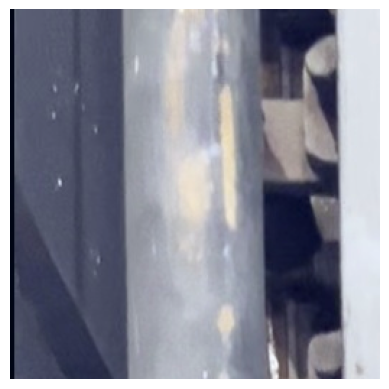

In [109]:
def show_tensor_image(tensor_image):
    # Convert the tensor to a NumPy array
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    plt.imshow(np_image)
    plt.axis('off')  # Turn off axis
    plt.show()

    
padding = 16
# Display the image
show_tensor_image(aa[0][:,padding:-padding,padding:-padding])

In [ ]:
#rgb_image = aa[1][16:-16,16:-16].to(torch.int32).numpy()
rgb_image = aa[1].to(torch.int32).numpy()

# 이미지 시각화
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.show()

In [110]:
from torchvision import models


def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    """UNet Model inspired by the the original UNet paper

    Parameters
    ----------
    pretrained: bool (default=True)
        Option to use pretrained vgg16_bn based on ImageNet

    References
    ----------

    .. [1] Olaf Ronneberger, Philipp Fischer, Thomas Brox, 2015,
        "U-Net: Convolutional Networks for Biomedical Image Segmentation,".
        "MICCAI" `<https://arxiv.org/abs/1505.04597>`_
    """
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT).features
        else:
            encoder = models.vgg16_bn(weights=None).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)
        # pdb.set_trace()

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

In [111]:
module = UNet(pretrained=True)

In [112]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

In [113]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.2,
                       step_size_up=10, #540,
                       step_size_down=10)

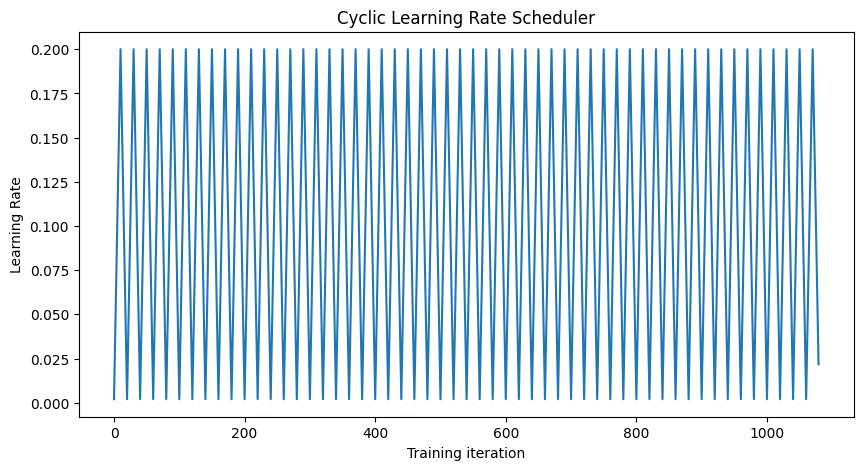

In [114]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
_ = ax.plot(cyclicLR.simulate(1080, 0.002))

In [115]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=(16,16)):
        super().__init__()
        self.padding = padding
        self.criterion = nn.MSELoss()

    def forward(self, inputs, target):
        # pdb.set_trace()
        inputs = inputs.squeeze_(
            dim=1)[:, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        target = target.squeeze_(
            dim=1)[:, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        # return binary_cross_entropy_with_logits(input, target)
        #print(criterion(input, target))
        return self.criterion(inputs, target)

In [116]:
from skorch.callbacks import Checkpoint
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    module,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=(16,16), #(16,20), 
    batch_size=32, #32,
    max_epochs=1,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    #iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    #iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               #iou_scoring,
               Checkpoint(f_params='best_params.pt')],
    device='cuda',
)

In [117]:
net.fit(train_ds);

In [118]:
net.load_params(f_params='best_params_iter100.pt')

In [119]:
#train_masks = net.predict(train_ds).squeeze(1)
val_masks = net.predict(val_ds).squeeze(1)
val_prob_masks = 1/(1 + np.exp(-val_masks))
val_masks.shape, val_prob_masks.shape, len(val_masks)

((240, 288, 288), (240, 288, 288), 240)

In [120]:
def show_numpy_image(np_image):
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    #plt.imshow(np_image, cmap='gray') 
    plt.imshow(np_image) 
    plt.axis('off')  # Turn off axis
    plt.show()

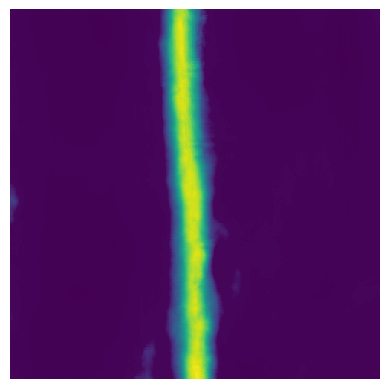

((240, 288, 288), (256, 256))

In [121]:
img = val_prob_masks[28][padding:-padding,padding:-padding]  # 0~1사이의 값, 배경은 0.5근방
show_numpy_image(img)
val_prob_masks.shape, img.shape

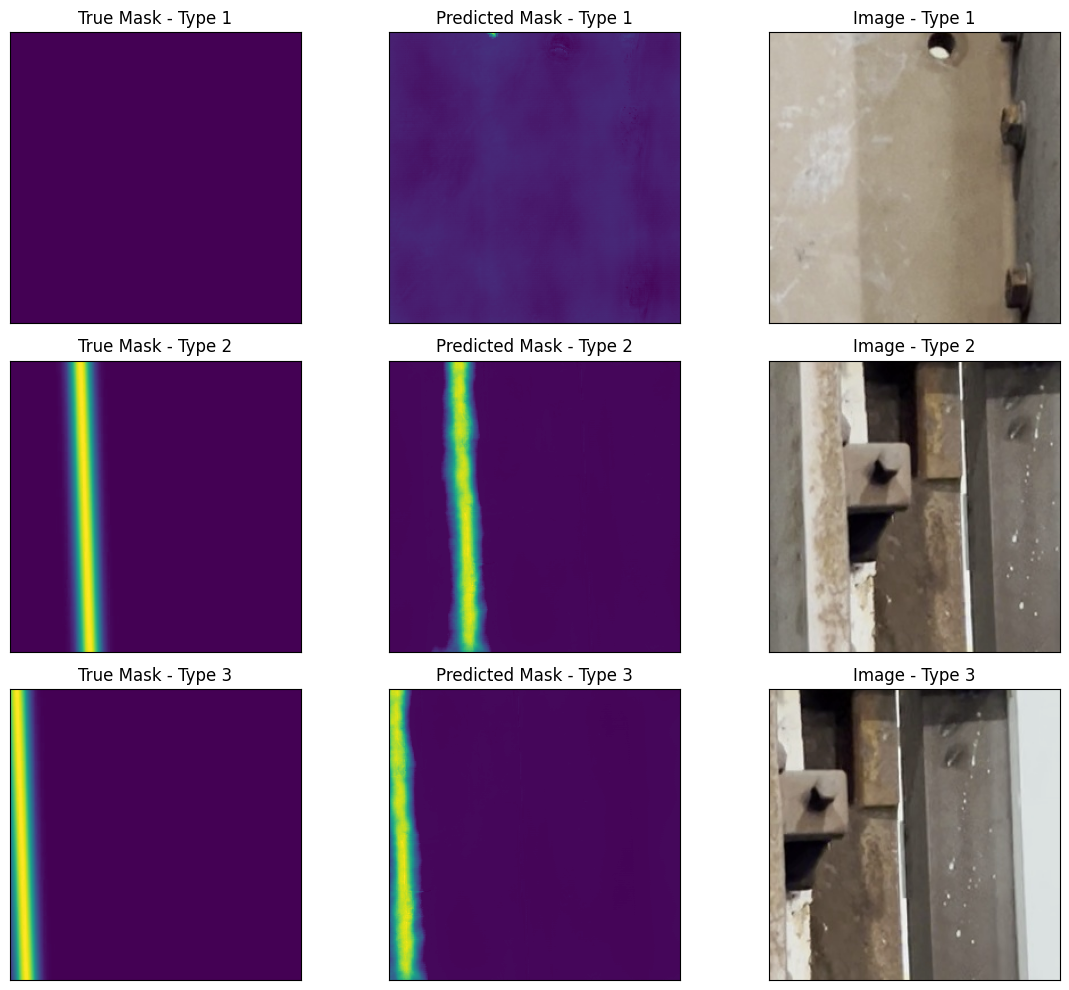

In [122]:
mask_cells = []
#for case_id in [45, 8, 81]:
#for case_id in [28, 29, 30]:
for case_id in [37, 38, 39]:    
#for case_id in [40, 41, 42]:    
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)

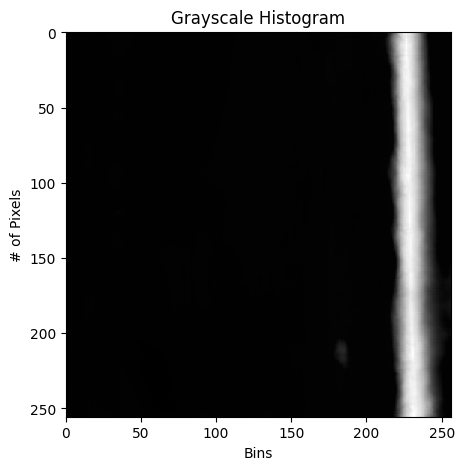

In [151]:
image_id = 0
org_img, org_mask = val_ds[image_id]
pred_mask = val_prob_masks[image_id][padding:-padding, padding:-padding] 

# 히스토그램 계산
hist = cv2.calcHist([pred_mask*255], [0], None, [256], [0, 256])

# 히스토그램 시각화
plt.figure(figsize=(10, 5))
plt.title('Grayscale Histogram')
plt.xlabel('Bins')
plt.ylabel('# of Pixels')
plt.imshow(pred_mask, cmap='gray')
#plt.plot(hist)
plt.xlim([0, 256])
plt.show()

Maximum psum: 184.39115154743195, Number of pixels on line: 255


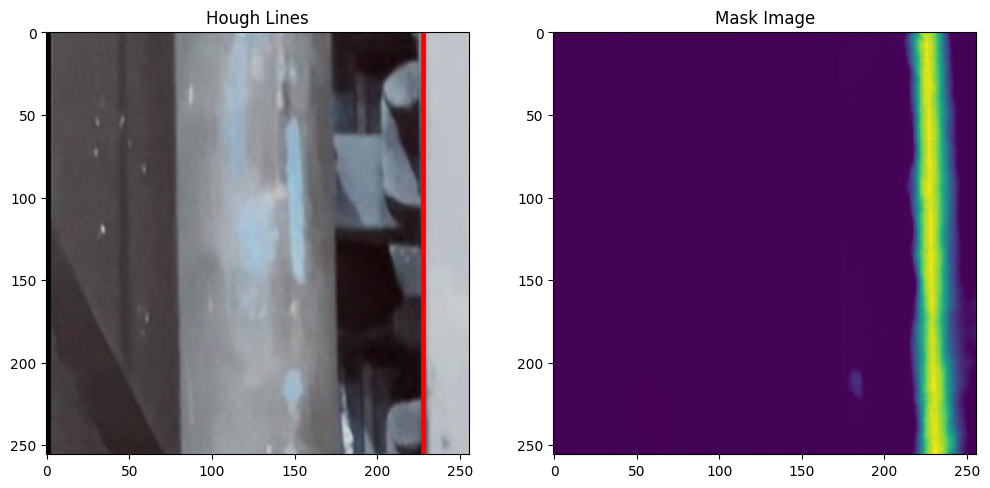

Maximum psum: 185.07747375965118, Number of pixels on line: 255


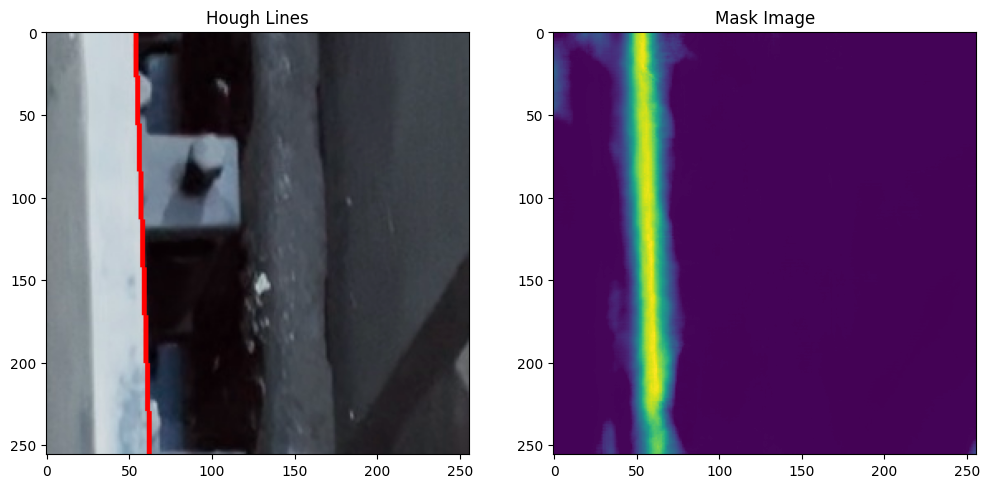

Maximum psum: 183.50173085927963, Number of pixels on line: 255


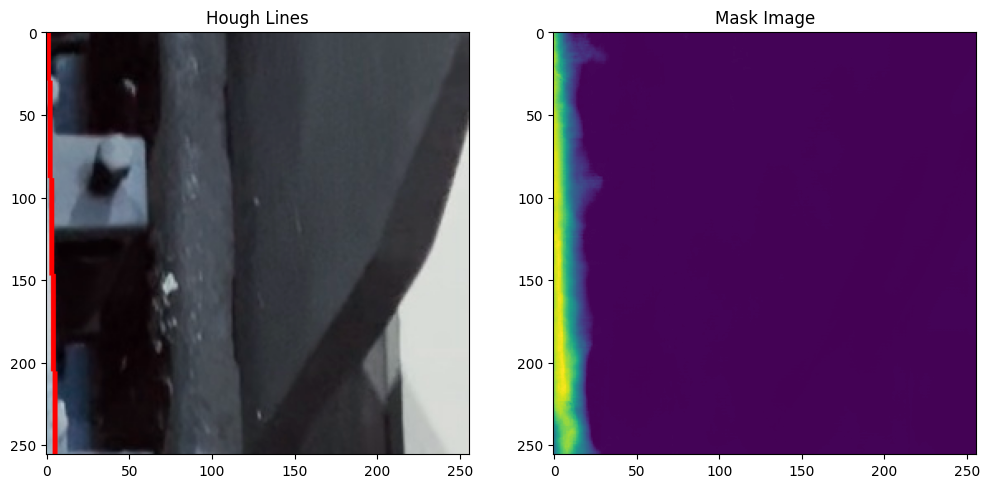

Maximum psum: 183.7229079604149, Number of pixels on line: 255


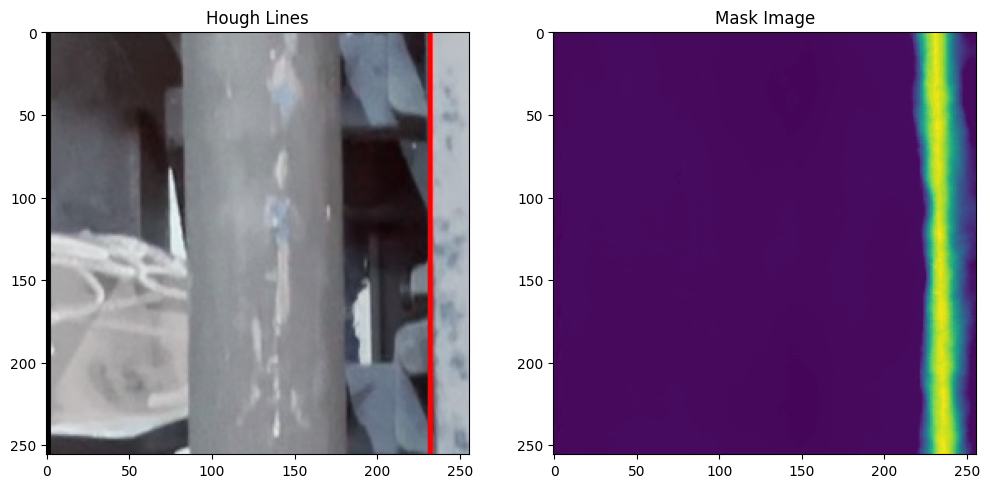

Maximum psum: 184.63190799951553, Number of pixels on line: 255


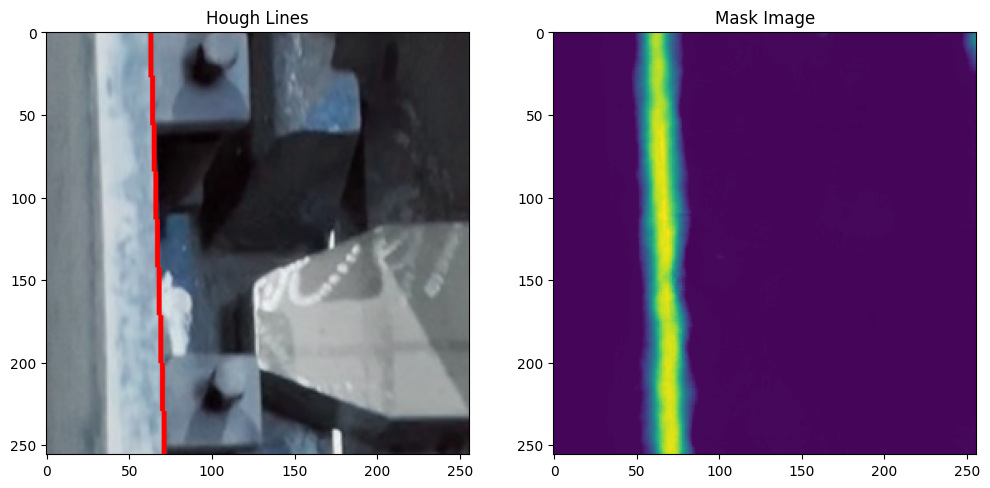

Maximum psum: 184.88664960861206, Number of pixels on line: 255


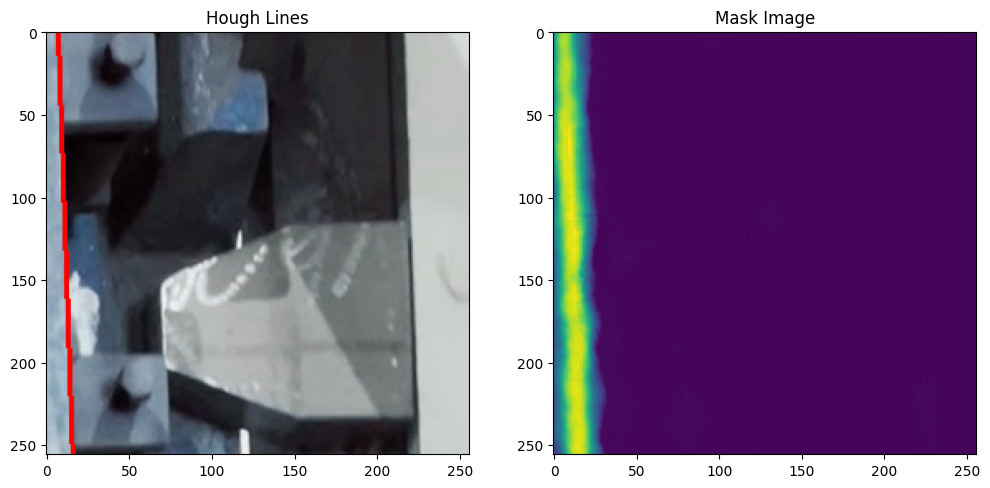

Maximum psum: 185.76290845870972, Number of pixels on line: 255


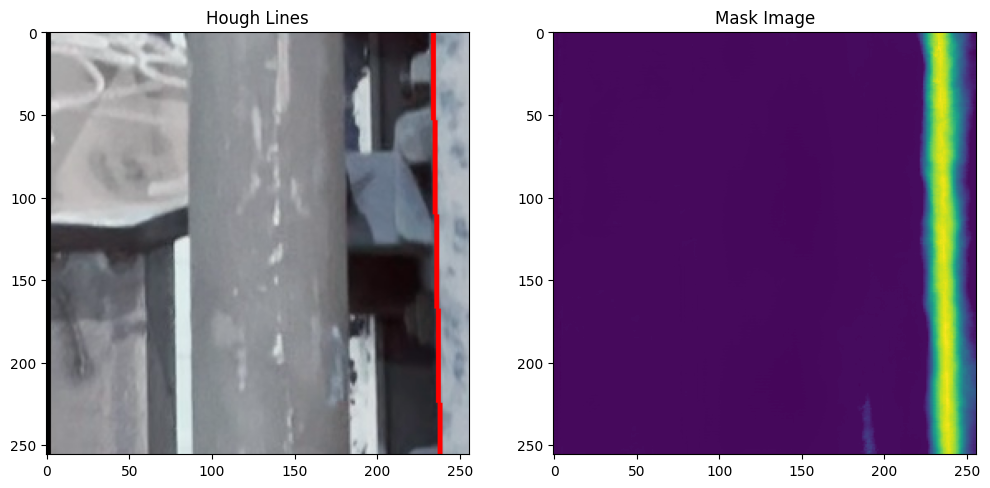

Maximum psum: 185.08621203899384, Number of pixels on line: 255


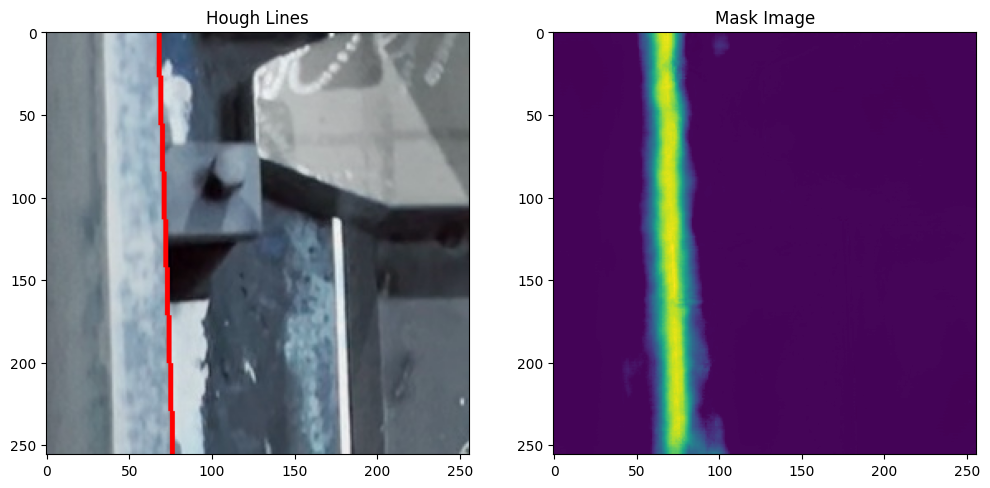

Maximum psum: 185.27927684783936, Number of pixels on line: 255


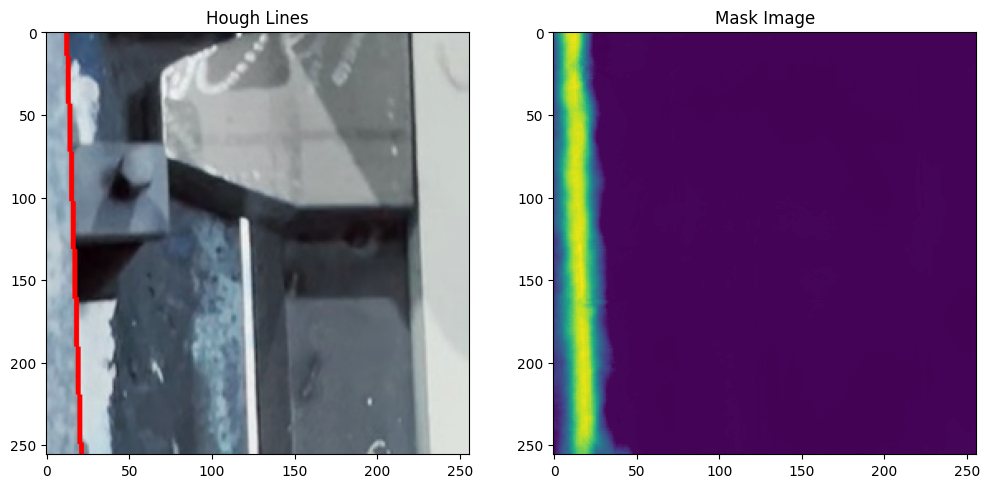

Maximum psum: 183.80286759138107, Number of pixels on line: 255


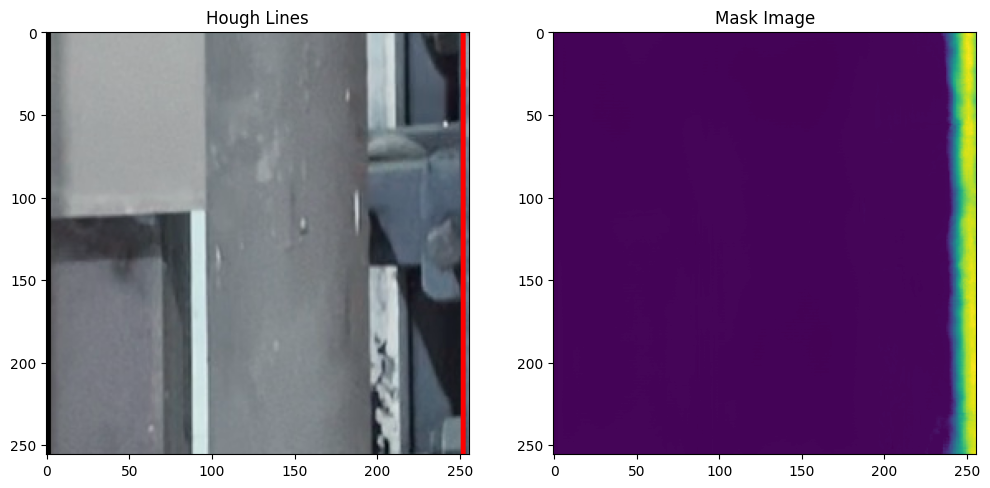

Maximum psum: 183.94448047876358, Number of pixels on line: 255


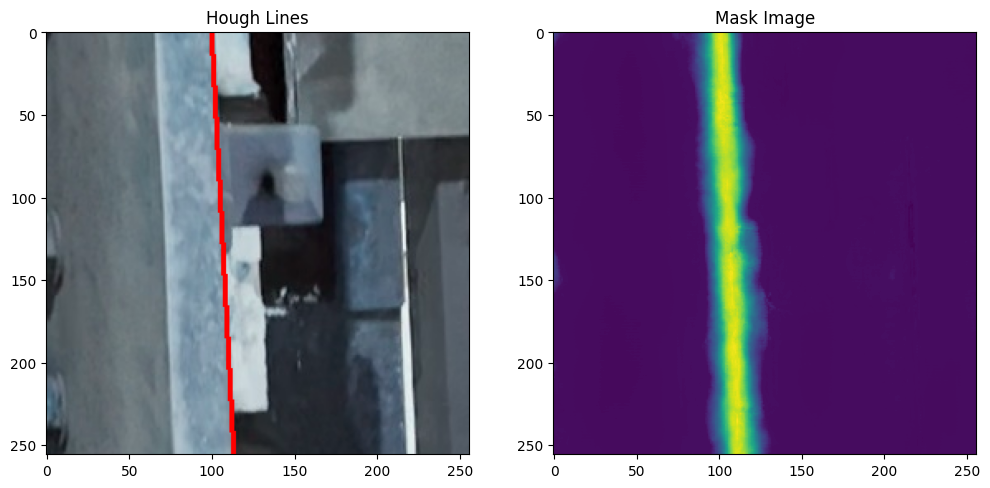

Maximum psum: 183.98088878393173, Number of pixels on line: 255


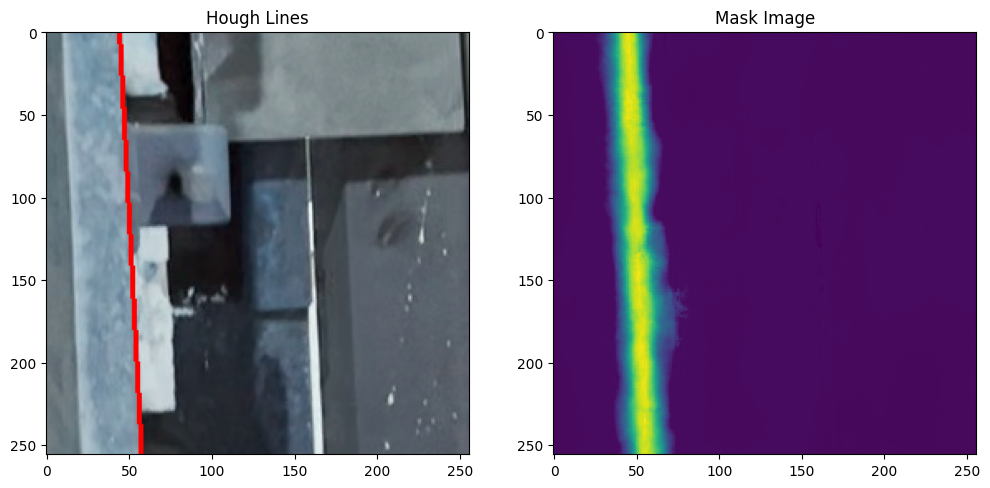

Maximum psum: 183.38406711816788, Number of pixels on line: 255


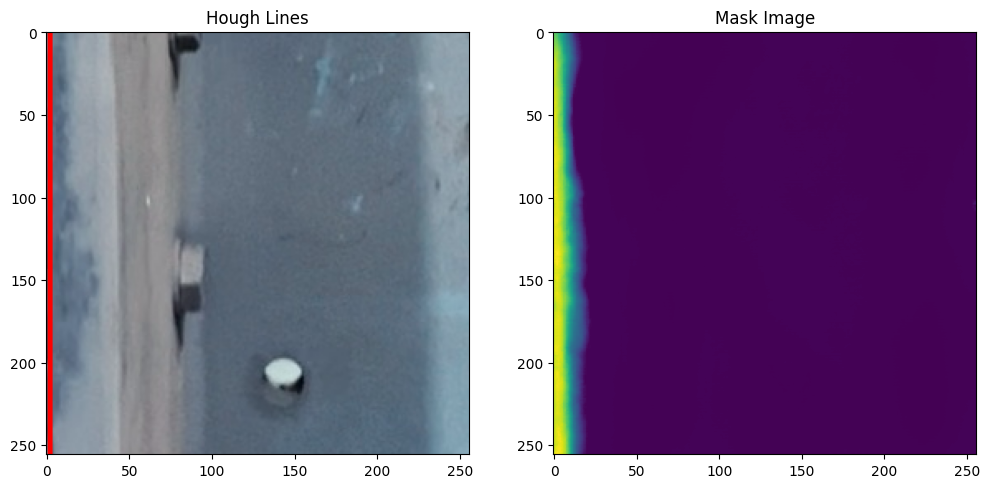

Maximum psum: 183.00294595956802, Number of pixels on line: 255


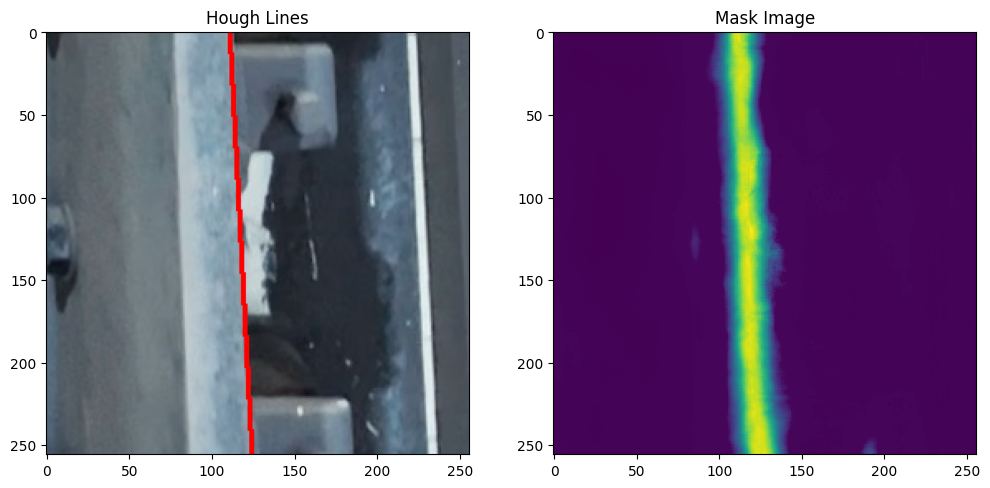

Maximum psum: 183.13769155740738, Number of pixels on line: 255


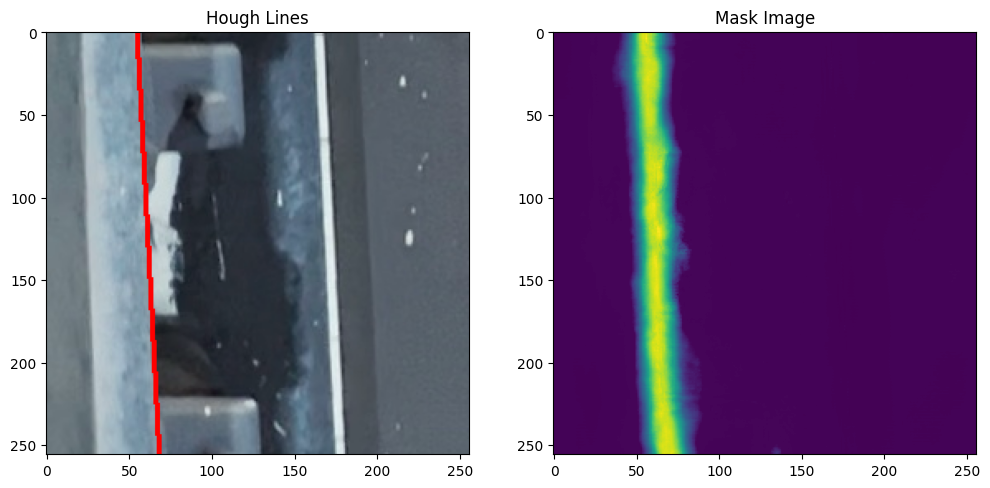

Maximum psum: 183.7133514881134, Number of pixels on line: 255


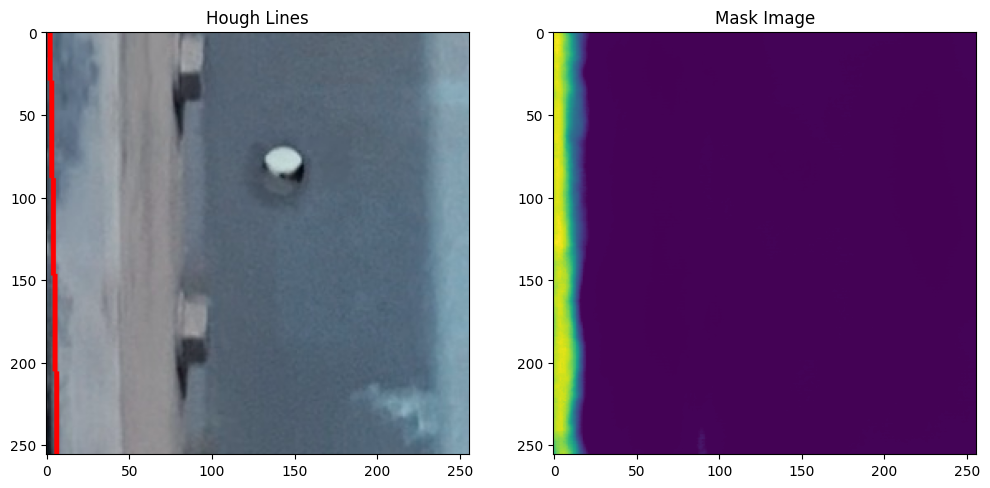

Maximum psum: 183.3358295559883, Number of pixels on line: 255


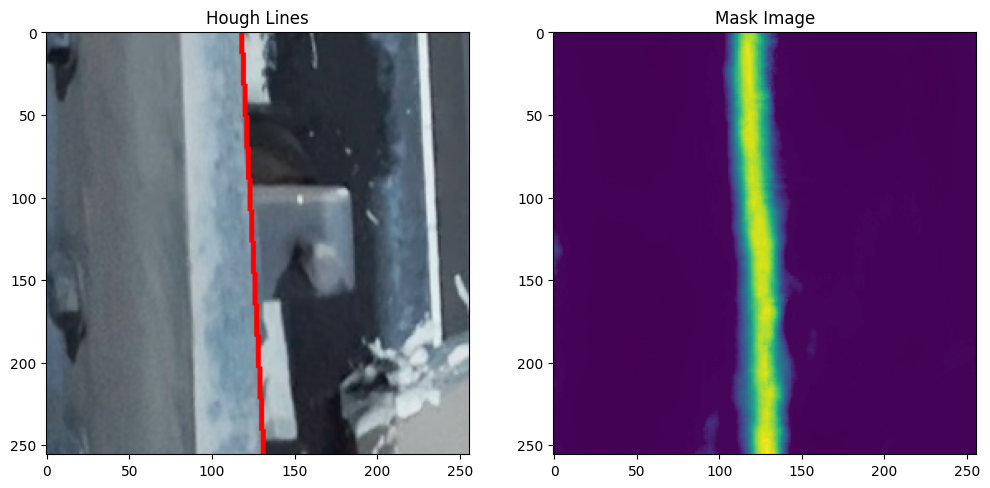

Maximum psum: 183.19636315107346, Number of pixels on line: 255


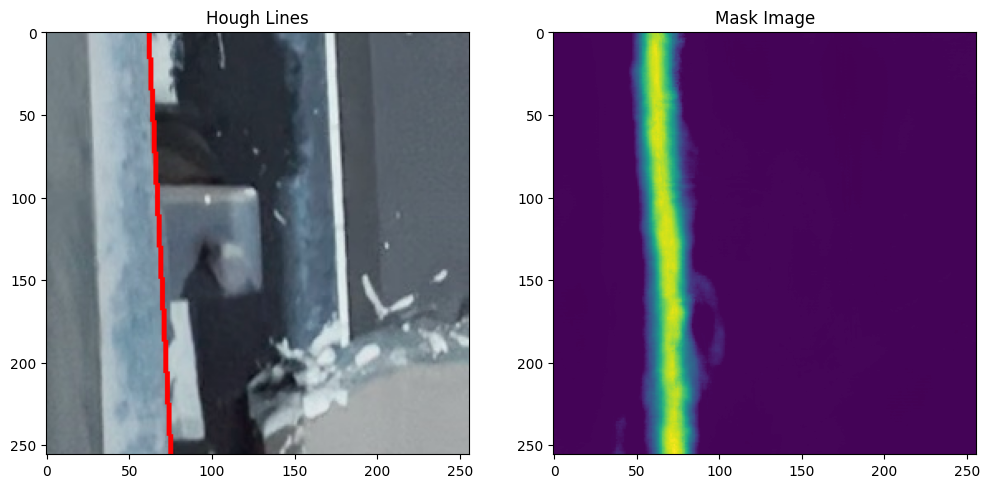

In [144]:
def strength_line(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

    # 선 위의 모든 픽셀 좌표 계산
    all_line_pixels = []
    for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
        x = int(x1 * (1 - t) + x2 * t)
        y = int(y1 * (1 - t) + y2 * t)
        if 0 < x < imsize[0] and 0 < y < imsize[1]:
            all_line_pixels.append((x, y))
            
    total_sum = sum(mask_im[y, x] for x, y in all_line_pixels)
    
    return image, total_sum, all_line_pixels


def points_on_line(org_img, pred_mask, mask_thres=0.7, \
                   wsize=5, sigma=1.4, low_thres=30, high_thres=80, min_length=50):
    ''' '''
    # Get numpy image
    pil_image = convert_cell_to_img(org_img, padding=16)
    image = np.array(pil_image)
    
    # 가우시안 블러를 사용하여 노이즈 감소
    blurred_image = cv2.GaussianBlur(image, (wsize, wsize), sigma)
    # Canny 에지 검출
    edges = cv2.Canny(blurred_image, low_thres, high_thres)

    result_image = np.where(pred_mask >= mask_thres, edges, 0)  
    lines = cv2.HoughLines(result_image, 1, np.pi / 180, min_length)
    
    return lines, image
    
    
def select_bestline(lines, src_image, pred_mask):
    votes = []
    if lines is not None:
        for idx, (rho, theta) in enumerate(lines[:, 0]):
            res_im, psum, all_line_pixels = strength_line(src_image.copy(), pred_mask, rho, theta)
            votes.append((res_im, psum, all_line_pixels))

        max_element = max(votes, key=lambda x: x[1])
        return max_element

    return None

    
def plot_line(image_id, val_ds, val_prob_masks, padding):
    # 검출된 선을 이미지에 그리기
    org_img, org_mask = val_ds[image_id]
    pred_mask = val_prob_masks[image_id][padding:-padding, padding:-padding] 

    lines, src_image = points_on_line(org_img, pred_mask)
    max_element = select_bestline(lines, src_image, pred_mask)
    if max_element:
        res_im_max, psum_max, all_line_pixels = max_element
        print(f"Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}")

        # 이미지 표시
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
        plt.title('Hough Lines')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask)
        plt.title('Mask Image')

        plt.show()


# 예제 실행
for idx in range(0, 30):
    plot_line(idx, val_ds, val_prob_masks, padding=16)

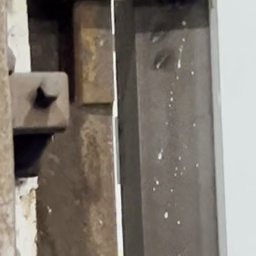

(None, (256, 256), (256, 256, 3))

In [96]:
image_id = 39  # 28 38 42
cell, mask = val_ds[image_id]  # source
pil_image = convert_cell_to_img(cell, padding=16)
image = np.array(pil_image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display(pil_image), pil_image.size, image.shape

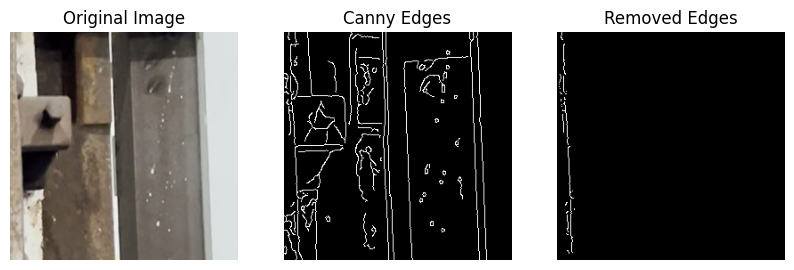

In [92]:
# 가우시안 블러를 사용하여 노이즈 감소
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

# Canny 에지 검출
low_threshold = 30
high_threshold = 80
edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

mask_image = val_prob_masks[image_id][padding:-padding,padding:-padding] 
result_image = np.where(mask_image >= 0.7, edges, 0)



# 원본 이미지와 에지 검출 결과를 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Canny Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Removed Edges')
plt.imshow(result_image, cmap='gray')
plt.axis('off')


plt.show()

183.41365122795105 [183.41365122795105, 183.01491820812225, 182.06600606441498, 176.3455572128296, 180.3412218093872] 255


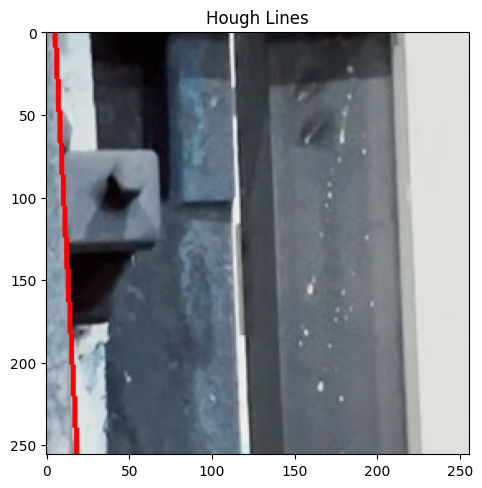

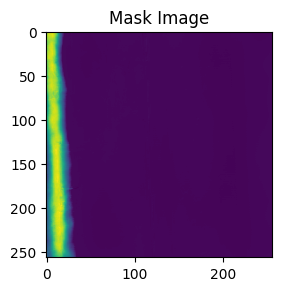

In [93]:
# Hough Line Transform 적용
image = np.array(pil_image)
lines = cv2.HoughLines(result_image, 1, np.pi / 180, 50)


# 검출된 선을 이미지에 그리기
msum = []
if lines is not None:
    for idx, (rho, theta) in enumerate(lines[:, 0]):
        res_im, psum, all_line_pixels = strength_line(image.copy(), mask_image, rho, theta)
        msum.append((res_im, psum, all_line_pixels))
            
max_element = max(msum, key=lambda x: x[1])
res_im_max, psum_max, all_line_pixels = max_element
print(psum_max, [x[1] for x in msum], len(all_line_pixels))        


# 이미지 표시
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
plt.title('Hough Lines')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.show()